# Autotalker

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 13.01.2023
- **Date of Last Modification:** 30.03.2023

- The Autotalker source code is available at https://github.com/Talavera-Lopez-Lab/autotalker.
- The workflow of this notebook follows the tutorial from https://github.com/sebastianbirk/autotalker/blob/main/notebooks/autotalker_tutorial.ipynb.
- It is recommended to use raw counts as input to Autotalker. Therefore, we use raw counts (stored in adata.layers["counts"]).

## 1. Setup

### 1.1 Import Libraries

In [4]:
import sys
sys.path.append("../../../autotalker")

In [12]:
import argparse
import os
import random
import time
import warnings
from copy import deepcopy
from datetime import datetime

import anndata as ad
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import seaborn as sns
import squidpy as sq
import torch
from matplotlib.pyplot import rc_context

from autotalker.models import Autotalker
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_mebocost_es_interactions,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions,
                              filter_and_combine_gp_dict_gps,
                              get_unique_genes_from_gp_dict)

### 1.2 Define Parameters

In [28]:
model_name = "autotalker"
latent_key = f"{model_name}_latent"
mapping_entity_key = "reference"
condition_key = "batch"
counts_key = "counts"
spatial_key = "spatial"
adj_key = "spatial_connectivities"
nichenet_keep_target_genes_ratio = 0.01
nichenet_max_n_target_genes_per_gp = 25344
include_mebocost_gps = True
mebocost_species = "mouse"
filter_genes = False
gp_filter_mode = "subset"
combine_overlap_gps = True
overlap_thresh_source_genes = 0.9
overlap_thresh_target_genes = 0.9
overlap_thresh_genes = 0.9
active_gp_names_key = "autotalker_active_gp_names"
gp_targets_mask_key = "autotalker_gp_targets_mask"
gp_sources_mask_key = "autotalker_gp_sources_mask"
gp_names_key = "autotalker_gp_names"
active_gp_thresh_ratio = 0.03
gene_expr_recon_dist = "nb"
cond_embed_injection = "gene_expr_decoder"
log_variational = True
n_layers_encoder = 1
conv_layer_encoder = "gcnconv"
n_epochs = 1
n_epochs_all_gps = 1
lr = 0.001
lambda_edge_recon = 1000.
lambda_gene_expr_recon = 1.
lambda_cond_contrastive = 100.
cond_contrastive_thresh = 0.8
lambda_group_lasso = 0.
lambda_l1_masked = 0.
edge_batch_size = 128
node_batch_size = 16
leiden_resolution = 0.01 # used for Leiden clustering of latent space; 0.1
random_seed = 0 # used for Leiden clustering

### 1.3 Run Notebook Setup

In [18]:
sc.set_figure_params(figsize=(6, 6))

In [19]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Directories

In [34]:
srt_data_gold_folder_path = "../../datasets/srt_data/gold/"
figure_folder_path = f"../../figures"
gp_data_folder_path = "../../datasets/gp_data" # gene program data
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"

# Create required directories
os.makedirs(gp_data_folder_path, exist_ok=True)
os.makedirs(srt_data_gold_folder_path + "/results", exist_ok=True)

## 2. Autotalker Model

### 2.1 Prepare Gene Program Mask

In [15]:
print("Preparing the gene program mask...")
# OmniPath gene programs
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=True,
    save_to_disk=False,
    file_path=omnipath_lr_interactions_file_path,
    plot_gp_gene_count_distributions=False)

omnipath_genes = get_unique_genes_from_gp_dict(
    gp_dict=omnipath_gp_dict,
    retrieved_gene_entities=["sources", "targets"])

# NicheNet gene programs
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_genes_ratio=nichenet_keep_target_genes_ratio,
    max_n_target_genes_per_gp=nichenet_max_n_target_genes_per_gp,
    load_from_disk=True,
    save_to_disk=False,
    file_path=nichenet_ligand_target_mx_file_path,
    plot_gp_gene_count_distributions=False)

nichenet_source_genes = get_unique_genes_from_gp_dict(
    gp_dict=nichenet_gp_dict,
    retrieved_gene_entities=["sources"])

# Combine gene programs into one dictionary
combined_gp_dict = dict(omnipath_gp_dict)
combined_gp_dict.update(nichenet_gp_dict)

if filter_genes:
    # Get gene program relevant genes
    gp_relevant_genes = list(set(omnipath_genes + nichenet_source_genes))

# Mebocost gene programs
if include_mebocost_gps:
    mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps/",
    species=mebocost_species,
    genes_uppercase=True,
    plot_gp_gene_count_distributions=False)
    
    mebocost_genes = get_unique_genes_from_gp_dict(
        gp_dict=mebocost_gp_dict,
        retrieved_gene_entities=["sources", "targets"])

    combined_gp_dict.update(mebocost_gp_dict)
    
    if filter_genes:
        # Update gene program relevant genes
        gp_relevant_genes = list(set(gp_relevant_genes + mebocost_genes))
    
# Filter and combine gene programs
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode=gp_filter_mode,
    combine_overlap_gps=combine_overlap_gps,
    overlap_thresh_source_genes=overlap_thresh_source_genes,
    overlap_thresh_target_genes=overlap_thresh_target_genes,
    overlap_thresh_genes=overlap_thresh_genes,
    verbose=False)

print("Number of gene programs before filtering and combining: "
      f"{len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: "
      f"{len(combined_new_gp_dict)}.")

Preparing the gene program mask...
Number of gene programs before filtering and combining: 1725.
Number of gene programs after filtering and combining: 1575.


### 2.2 Define Training Function

In [31]:
def train_autotalker_models(dataset,
                            reference_batches,
                            cell_type_key,
                            adata_new=None,
                            n_start_run=1,
                            n_end_run=10,
                            n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20],
                            plot_latent_umaps: bool=False):
    # Create new adata to store results from training runs in storage-efficient way
    if adata_new is None:  
        adata_batch_list = []
        if reference_batches is not None:
            for batch in reference_batches:
                adata_batch = ad.read_h5ad(
                    f"{srt_data_gold_folder_path}/{dataset}_{batch}.h5ad")
                adata_batch.obs[mapping_entity_key] = "reference"
                adata_batch_list.append(adata_batch)
            adata_original = ad.concat(adata_batch_list, join="inner")
        else:
            adata_original = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}.h5ad")

        adata_new = sc.AnnData(sp.csr_matrix(
            (adata_original.shape[0], adata_original.shape[1]),
            dtype=np.float32))
        adata_new.var_names = adata_original.var_names
        adata_new.obs_names = adata_original.obs_names
        adata_new.obs["cell_type"] = adata_original.obs[cell_type_key].values
        adata_new.obsm["spatial"] = adata_original.obsm["spatial"]
        adata_new.obs[condition_key] = adata_original.obs[condition_key]
        adata_new.obs[mapping_entity_key] = adata_original.obs[mapping_entity_key] 
        del(adata_original)
    
    model_seeds = list(range(10))
    for run_number, n_neighbors in zip(np.arange(n_start_run, n_end_run+1), n_neighbor_list):
        # Load data
        adata_batch_list = []
        if reference_batches is not None:
            for batch in reference_batches:
                print(f"Processing batch {batch}...")
                print("Loading data...")
                adata_batch = ad.read_h5ad(
                    f"{srt_data_gold_folder_path}/{dataset}_{batch}.h5ad")
                adata_batch.obs[mapping_entity_key] = "reference"
                print("Computing spatial neighborhood graph...\n")
                # Compute (separate) spatial neighborhood graphs
                sq.gr.spatial_neighbors(adata_batch,
                                        coord_type="generic",
                                        spatial_key=spatial_key,
                                        n_neighs=n_neighbors)
                # Make adjacency matrix symmetric
                adata_batch.obsp[adj_key] = (
                    adata_batch.obsp[adj_key].maximum(
                        adata_batch.obsp[adj_key].T))
                adata_batch_list.append(adata_batch)
            adata = ad.concat(adata_batch_list, join="inner")

            # Combine spatial neighborhood graphs as disconnected components
            batch_connectivities = []
            len_before_batch = 0
            for i in range(len(adata_batch_list)):
                if i == 0: # first batch
                    after_batch_connectivities_extension = sp.csr_matrix(
                        (adata_batch_list[0].shape[0],
                        (adata.shape[0] -
                        adata_batch_list[0].shape[0])))
                    batch_connectivities.append(sp.hstack(
                        (adata_batch_list[0].obsp[adj_key],
                        after_batch_connectivities_extension)))
                elif i == (len(adata_batch_list) - 1): # last batch
                    before_batch_connectivities_extension = sp.csr_matrix(
                        (adata_batch_list[i].shape[0],
                        (adata.shape[0] -
                        adata_batch_list[i].shape[0])))
                    batch_connectivities.append(sp.hstack(
                        (before_batch_connectivities_extension,
                        adata_batch_list[i].obsp[adj_key])))
                else: # middle batches
                    before_batch_connectivities_extension = sp.csr_matrix(
                        (adata_batch_list[i].shape[0], len_before_batch))
                    after_batch_connectivities_extension = sp.csr_matrix(
                        (adata_batch_list[i].shape[0],
                        (adata.shape[0] -
                        adata_batch_list[i].shape[0] -
                        len_before_batch)))
                    batch_connectivities.append(sp.hstack(
                        (before_batch_connectivities_extension,
                        adata_batch_list[i].obsp[adj_key],
                        after_batch_connectivities_extension)))
                len_before_batch += adata_batch_list[i].shape[0]
            connectivities = sp.vstack(batch_connectivities)
            adata.obsp[adj_key] = connectivities
        else:
            adata = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}.h5ad")
            # Compute (separate) spatial neighborhood graphs
            sq.gr.spatial_neighbors(adata,
                                    coord_type="generic",
                                    spatial_key=spatial_key,
                                    n_neighs=n_neighbors)
            # Make adjacency matrix symmetric
            adata.obsp[adj_key] = (
                adata.obsp[adj_key].maximum(
                    adata.obsp[adj_key].T))
            
        # Filter genes if specified
        if filter_genes:
            print("\nFiltering genes...")
            # Filter genes and only keep ligand, receptor, metabolitye enzyme, 
            # metabolite sensor and the 'n_hvg' highly variable genes (potential target
            # genes of nichenet)
            gp_dict_genes = get_unique_genes_from_gp_dict(
                gp_dict=combined_new_gp_dict,
                retrieved_gene_entities=["sources", "targets"])
            print(f"Starting with {len(adata.var_names)} genes.")
            sc.pp.filter_genes(adata,
                               min_cells=0)
            print(f"Keeping {len(adata.var_names)} genes after filtering "
                  "genes with expression in 0 cells.")

            if counts_key is not None:
                hvg_layer = counts_key
                if (adata.layers[counts_key].astype(int).sum() == 
                adata.layers[counts_key].sum()): # raw counts
                    hvg_flavor = "seurat_v3"
                else:
                    hvg_flavor = "seurat" # log normalized counts
            else:
                hvg_layer = None
                if adata.X.astype(int).sum() == adata.X.sum(): # raw counts
                    hvg_flavor = "seurat_v3"
                else: # log normalized counts
                    hvg_flavor = "seurat"

            sc.pp.highly_variable_genes(
                adata,
                layer=hvg_layer,
                n_top_genes=n_hvg,
                flavor=hvg_flavor,
                batch_key=condition_key,
                subset=False)

            adata.var["gp_relevant"] = (
                adata.var.index.str.upper().isin(gp_relevant_genes))
            adata.var["keep_gene"] = (adata.var["gp_relevant"] | 
                                                adata.var["highly_variable"])
            adata = (
                adata[:, adata.var["keep_gene"] == True])
            print(f"Keeping {len(adata.var_names)} highly variable or gene "
                  "program relevant genes.")
            adata = (
                adata[:, adata.var_names[
                    adata.var_names.str.upper().isin(
                        gp_dict_genes)].sort_values()])
            print(f"Keeping {len(adata.var_names)} genes after filtering "
                  "genes not in gp dict.")
        
        # Add the gene program dictionary as binary masks to the adata for model 
        # training
        add_gps_from_gp_dict_to_adata(
            gp_dict=combined_new_gp_dict,
            adata=adata,
            genes_uppercase=True,
            gp_targets_mask_key=gp_targets_mask_key,
            gp_sources_mask_key=gp_sources_mask_key,
            gp_names_key=gp_names_key,
            min_genes_per_gp=1,
            min_source_genes_per_gp=0,
            min_target_genes_per_gp=0,
            max_genes_per_gp=None,
            max_source_genes_per_gp=None,
            max_target_genes_per_gp=None,
            filter_genes_not_in_masks=False)

        # Determine dimensionality of hidden encoder
        n_hidden_encoder = len(adata.uns[f"{model_name}_gp_names"])
        n_cond_embed = int(len(adata.var_names) / 2)

        start_time = time.time()
        
        print("\nTraining model...")
        # Initialize model
        model = Autotalker(adata,
                           counts_key=counts_key,
                           adj_key=adj_key,
                           condition_key=condition_key,
                           cond_embed_injection=cond_embed_injection,
                           n_cond_embed=n_cond_embed,
                           gp_names_key=gp_names_key,
                           active_gp_names_key=active_gp_names_key,
                           gp_targets_mask_key=gp_targets_mask_key,
                           gp_sources_mask_key=gp_sources_mask_key,
                           latent_key=latent_key,
                           active_gp_thresh_ratio=active_gp_thresh_ratio,
                           gene_expr_recon_dist=gene_expr_recon_dist,
                           n_layers_encoder=n_layers_encoder,
                           conv_layer_encoder=conv_layer_encoder,
                           n_hidden_encoder=n_hidden_encoder,
                           log_variational=log_variational)

        # Train model
        model.train(n_epochs=n_epochs,
                    n_epochs_all_gps=n_epochs_all_gps,
                    lr=lr,
                    lambda_edge_recon=lambda_edge_recon,
                    lambda_gene_expr_recon=lambda_gene_expr_recon,
                    lambda_cond_contrastive=lambda_cond_contrastive,
                    cond_contrastive_thresh=cond_contrastive_thresh,
                    lambda_group_lasso=lambda_group_lasso,
                    lambda_l1_masked=lambda_l1_masked,
                    edge_batch_size=edge_batch_size,
                    node_batch_size=node_batch_size,
                    seed=model_seeds[run_number-1],
                    verbose=True)        
        
        # Measure time for model training
        end_time = time.time()
        elapsed_time = end_time - start_time
        hours, rem = divmod(elapsed_time, 3600)
        minutes, seconds = divmod(rem, 60)
        print(f"Duration of model training in run {run_number}: "
              f"{int(hours)} hours, {int(minutes)} minutes and {int(seconds)} seconds.")
        adata_new.uns[f"{model_name}_model_training_duration_run{run_number}"] = (
            elapsed_time)

        if plot_latent_umaps:
            # Configure figure folder path
            dataset_figure_folder_path = f"{figure_folder_path}/{dataset}/sample_integration_method_benchmarking/" \
                                         f"{model_name}/{current_timestamp}"
            os.makedirs(dataset_figure_folder_path, exist_ok=True)
            
            # Use Autotalker latent space for UMAP generation
            sc.pp.neighbors(adata,
                            use_rep=latent_key,
                            n_neighbors=n_neighbors)
            sc.tl.umap(adata)
            fig = sc.pl.umap(adata,
                             color=[cell_type_key],
                             title=f"Latent Space with Cell Types: {model_name.capitalize()}",
                             return_fig=True)
            fig.savefig(f"{dataset_figure_folder_path}/latent_{model_name}"
                        f"_cell_types_run{run_number}.png",
                        bbox_inches="tight")

            # Compute latent Leiden clustering
            sc.tl.leiden(adata=adata,
                         resolution=leiden_resolution,
                         random_state=random_seed,
                         key_added=f"latent_{model_name}_leiden_{str(leiden_resolution)}")

            # Create subplot of latent Leiden cluster annotations in physical and latent space
            fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 12))
            title = fig.suptitle(t="Latent and Physical Space with Leiden Clusters: "
                                   f"{model_name.capitalize()}")
            sc.pl.umap(adata=adata,
                       color=[f"latent_{model_name}_leiden_{str(leiden_resolution)}"],
                       title=f"Latent Space with Leiden Clusters",
                       ax=axs[0],
                       show=False)
            sq.pl.spatial_scatter(adata=adata,
                                  color=[f"latent_{model_name}_leiden_{str(leiden_resolution)}"],
                                  title=f"Physical Space with Leiden Clusters",
                                  shape=None,
                                  ax=axs[1])

            # Create and position shared legend
            handles, labels = axs[0].get_legend_handles_labels()
            lgd = fig.legend(handles, labels, bbox_to_anchor=(1.25, 0.9185))
            axs[0].get_legend().remove()
            axs[1].get_legend().remove()

            # Adjust, save and display plot
            plt.subplots_adjust(wspace=0, hspace=0.2)
            fig.savefig(f"{dataset_figure_folder_path}/latent_physical_comparison_"
                        f"{model_name}_run{run_number}.png",
                        bbox_extra_artists=(lgd, title),
                        bbox_inches="tight")
            plt.show()

        # Store latent representation
        adata_new.obsm[latent_key + f"_run{run_number}"] = adata.obsm[latent_key]
        
        # Use latent representation for UMAP generation
        sc.pp.neighbors(adata_new,
                        use_rep=f"{latent_key}_run{run_number}",
                        key_added=f"{latent_key}_run{run_number}")
        sc.tl.umap(adata_new,
                   neighbors_key=f"{latent_key}_run{run_number}")
        adata_new.obsm[f"{latent_key}_run{run_number}_X_umap"] = adata_new.obsm["X_umap"]
        del(adata_new.obsm["X_umap"])

        # Store intermediate adata to disk
        adata_new.write(f"{srt_data_gold_folder_path}/results/{dataset}_{model_name}_oneshot_integrated.h5ad")  

    # Store final adata to disk
    adata_new.write(f"{srt_data_gold_folder_path}/results/{dataset}_{model_name}_oneshot_integrated.h5ad") 

### 2.3 Train Models on Benchmarking Datasets

In [35]:
train_autotalker_models(dataset="seqfish_mouse_organogenesis",
                        reference_batches=[f"batch{i}" for i in range(1,7)],
                        cell_type_key="celltype_mapped_refined",
                        adata_new=None,
                        n_start_run=1,
                        n_end_run=10,
                        n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20])

Processing batch batch1...
Loading data...
Computing spatial neighborhood graph...

Processing batch batch2...
Loading data...
Computing spatial neighborhood graph...

Processing batch batch3...
Loading data...
Computing spatial neighborhood graph...

Processing batch batch4...
Loading data...
Computing spatial neighborhood graph...

Processing batch batch5...
Loading data...
Computing spatial neighborhood graph...

Processing batch batch6...
Loading data...
Computing spatial neighborhood graph...


Training model...
--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> True
CONDITIONAL EMBEDDING INJECTION -> gene_expr_decoder
GRAPH ENCODER -> n_input: 351, n_cond_embed_input: 0, n_layers: 1, n_hidden: 489, n_latent: 489, n_addon_latent: 0, conv_layer: gcnconv, n_atte

KeyboardInterrupt: 

In [38]:
adata = sc.read_h5ad("../../datasets/srt_data/gold/results/seqfish_mouse_organogenesis_autotalker_oneshot_integrated.h5ad")

In [39]:
adata

AnnData object with n_obs × n_vars = 52568 × 351
    obs: 'cell_type', 'batch', 'reference'
    uns: 'autotalker_latent_run1', 'autotalker_model_training_duration_run1', 'umap'
    obsm: 'autotalker_latent_run1', 'autotalker_latent_run1_X_umap', 'spatial'
    obsp: 'autotalker_latent_run1_connectivities', 'autotalker_latent_run1_distances'

/home/mo/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mo/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Text(0.5, 1.0, 'One-Shot Integration: autotalker Latent Cell Type Annotations')

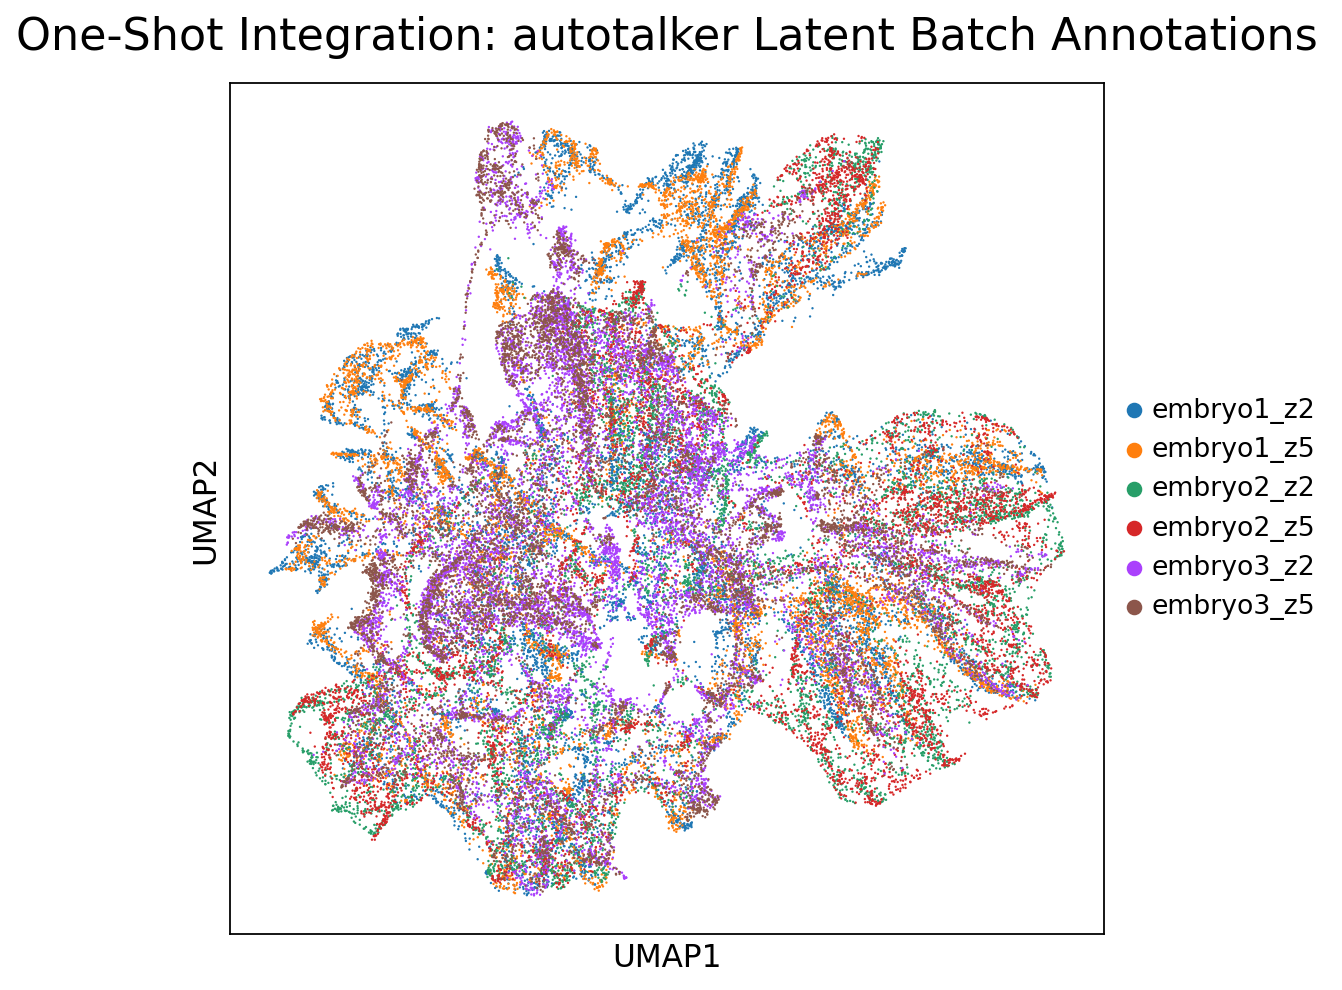

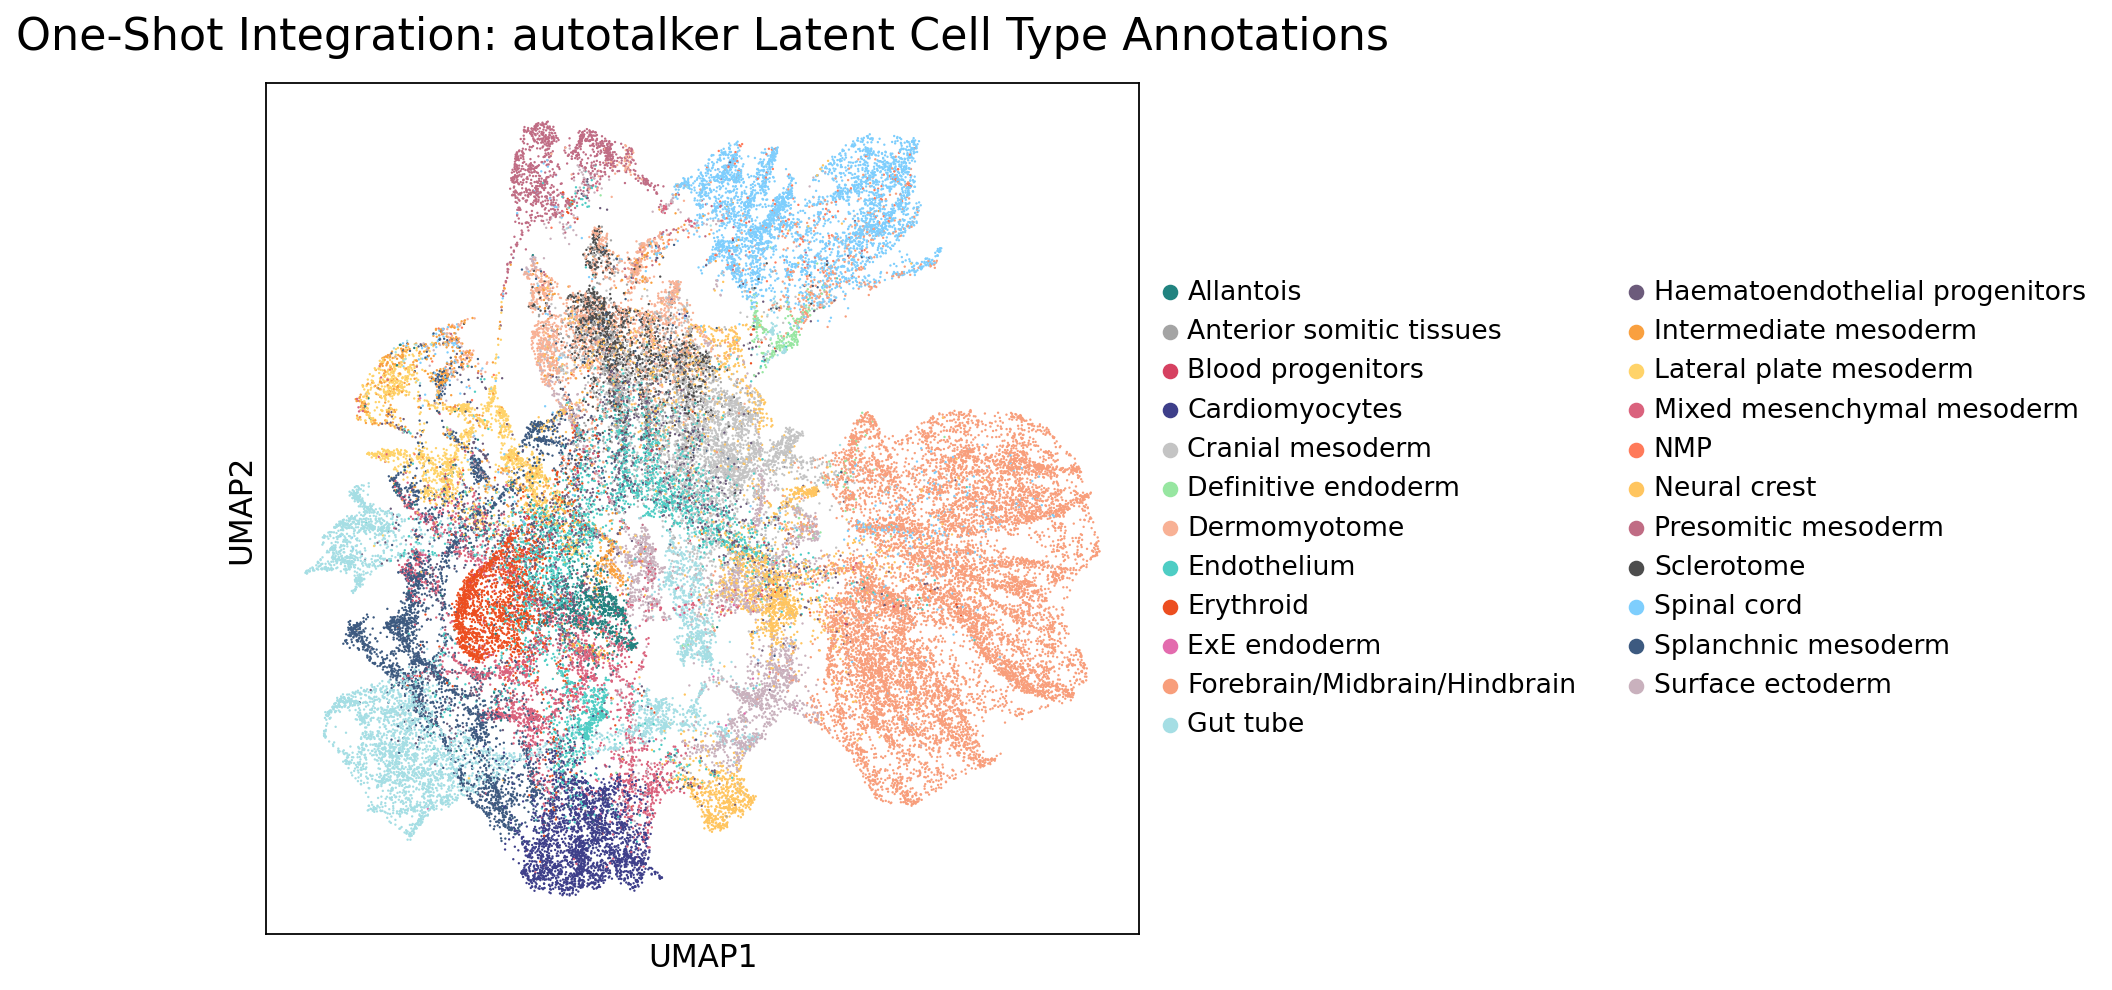

In [50]:
sys.path.append("..")
from color_utils import seqfish_mouse_organogenesis_cell_type_colors

adata.obsm["X_umap"] = adata.obsm["autotalker_latent_run1_X_umap"]
cell_type_key = "cell_type"

# Plot UMAP with batch annotations
fig = sc.pl.umap(adata,
                 color=[condition_key],
                 legend_fontsize=12,
                 size=240000/len(adata),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)
plt.title(f"One-Shot Integration: {model_name} Latent Batch Annotations", size=20, pad=15)

# Plot UMAP with cell type annotations
fig = sc.pl.umap(adata,
                 color=[cell_type_key],
                 palette=seqfish_mouse_organogenesis_cell_type_colors,
                 legend_fontsize=12,
                 size=240000/len(adata),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)
plt.title(f"One-Shot Integration: {model_name} Latent Cell Type Annotations", size=20, pad=15)

In [58]:
from autotalker.benchmarking import compute_clisis, compute_cas
import scib

spatial_knng_key = "autotalker_spatial_knng"
latent_knng_key = "autotalker_latent_run1"

# Compute metrics
metrics_dict = {}

# Spatial conservation metrics
metrics_dict["cas"] = compute_cas(
    adata=adata,
    cell_type_key=cell_type_key,
    condition_key=condition_key,
    spatial_knng_key=spatial_knng_key,
    latent_knng_key=latent_knng_key,
    spatial_key=spatial_key,
    latent_key=latent_key)
metrics_dict["clisis"] = compute_clisis(
    adata=adata,
    cell_type_key=cell_type_key,
    condition_key=condition_key,
    spatial_knng_key=spatial_knng_key,
    latent_knng_key=latent_knng_key,
    spatial_key=spatial_key,
    latent_key=latent_key)

# Batch correction metrics
metrics_dict["asw"] = scib.me.silhouette_batch(
    adata=adata,
    batch_key=condition_key,
    label_key=cell_type_key,
    embed=latent_key)
metrics_dict["ilisi"] = scib.me.ilisi_graph(
    adata=adata,
    batch_key=condition_key,
    type_="embed",
    use_rep=latent_key)
    #type_="knn")

Computing spatial nearest neighbor graph for batch embryo1_z2...
Computing spatial neighborhood enrichment scores for batch embryo1_z2...
Computing spatial nearest neighbor graph for batch embryo1_z5...
Computing spatial neighborhood enrichment scores for batch embryo1_z5...
Computing spatial nearest neighbor graph for batch embryo2_z2...
Computing spatial neighborhood enrichment scores for batch embryo2_z2...
Computing spatial nearest neighbor graph for batch embryo2_z5...
Computing spatial neighborhood enrichment scores for batch embryo2_z5...


/home/mo/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing spatial nearest neighbor graph for batch embryo3_z2...
Computing spatial neighborhood enrichment scores for batch embryo3_z2...
Computing spatial nearest neighbor graph for batch embryo3_z5...
Computing spatial neighborhood enrichment scores for batch embryo3_z5...
Combining spatial neighborhood enrichment scores across conditions...
Using precomputed latent nearest neighbor graph...
Computing latent neighborhood enrichment scores...
Computing CAS...
Computing spatial nearest neighbor graph for batch embryo1_z2...


/home/mo/miniconda3/envs/autotalker/lib/python3.9/site-packages/scib/knn_graph/knn_graph.o: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.34' not found (required by /home/mo/miniconda3/envs/autotalker/lib/python3.9/site-packages/scib/knn_graph/knn_graph.o)
/home/mo/miniconda3/envs/autotalker/lib/python3.9/site-packages/scib/knn_graph/knn_graph.o: /usr/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /home/mo/miniconda3/envs/autotalker/lib/python3.9/site-packages/scib/knn_graph/knn_graph.o)


FileNotFoundError: [Errno 2] No such file or directory: '/tmp/lisi_e99_pdni/graph_lisi_indices_0.txt'

In [ ]:
metrics_dict